In [1]:
import os
import re

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.figsize'] = (16, 9)

In [4]:
ROOT_DIR = "RawData"

In [5]:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("notebook", font_scale = 1.5)

# 1. Upload Datasets

In [6]:
def get_data(filename, dir = ROOT_DIR, force_download = False):
    if force_download or not os.path.exists(filename):
        data = pd.ExcelFile(os.path.join(dir, filename))
    return data

In [7]:
BE_data = get_data('BE_RawData_VPython.xlsx')
FR_data = get_data('FR_RawData_VPython.xlsx')
EU_data = get_data('EU_RawData_VPython.xlsx')

In [8]:
print("BE_data, sheet names = \n", BE_data.sheet_names, "\n\n", 
      "FR_data, sheet names = \n", FR_data.sheet_names, "\n\n", 
      "EU_data, sheet names = \n", EU_data.sheet_names, "\n")

BE_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'FlatGlassInd_GlassInd', 'RawMat_GlassInd_ABS'] 

 FR_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'RawMat_PlateGlass', 'RawMat_WindowGlass', 'RawMat_FloatGlass', 'RawMat_FlatGlass_ABS', 'pollution'] 

 EU_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'EnergyUse', 'pollution', 'production costs'] 



# 2. Production since 1945 in Belgium, France, and the European Union

## a. Production of flat glass

In [9]:
#Creating a DataFrame only with production data
FR_Prod = FR_data.parse('prod').set_index('year')
BE_Prod = BE_data.parse('prod').set_index('year')

#Creating a new DataFrame for Belgian and French flat glass production

BE_FR_Prod = FR_Prod[['flat glass INSEE, kt',
                      'flat glass SESSI, kt']].copy()
BE_FR_Prod.rename(columns={'flat glass INSEE, kt': 'FR, INSEE', 
                           'flat glass SESSI, kt': 'FR, SESSI'},
                  inplace=True)

BE_FR_Prod['Belgium'] = BE_Prod['flat glass, kt']

BE_FR_Prod

,"FR, INSEE","FR, SESSI",Belgium
year,,,
1945,108.3,NaN,NaN
1946,173.7,NaN,NaN
1947,198.3,NaN,NaN
1948,220.2,NaN,NaN
1949,191.3,NaN,NaN
...,...,...,...
2016,NaN,NaN,NaN
2017,NaN,NaN,NaN
2018,NaN,NaN,NaN


In [10]:
EU_Prod = EU_data.parse('prod').set_index(['Nbr of countries', 'year'])
EU_Prod

flat glass, kt bldg glass/flat glass, %  IGU, "000 m²  \
Nbr of countries year                                                          
6                1945             NaN                      NaN           NaN   
                 1946             NaN                      NaN           NaN   
                 1947             NaN                      NaN           NaN   
                 1948             NaN                      NaN           NaN   
                 1949             NaN                      NaN           NaN   
...                               ...                      ...           ...   
28               2015          9641.0                      NaN    116000.000   
                 2016          9835.0                      NaN    114000.000   
                 2017         10665.0                      NaN    121600.000   
                 2018         10643.0                      0.8    117011.436   
                 2019         10840.0                      NaN    121061.246   

                       float glass w/ reflecting layer, "000 m²  \
Nbr of countries year                                             
6                1945                                       NaN   
                 1946                                       NaN   
                 1947                                       NaN   
                 1948                                       NaN   
                 1949                                       NaN   
...                                                         ...   
28               2015                                290030.243   
                 2016                                302527.228   
                 2017                                286038.313   
                 2018                                287262.007   
                 2019                                296506.851   

                       LSG for bldg, "000 m²  TSG for bldg, "000 m²  
Nbr of countries year                                                
6                1945                    NaN                    NaN  
                 1946                    NaN                    NaN  
                 1947                    NaN                    NaN  
                 1948                    NaN                    NaN  
                 1949                    NaN                    NaN  
...                                      ...                    ...  
28               2015              94520.954              57000.000  
                 2016              85681.248              55864.316  
                 2017              86735.168              57552.178  
                 2018              84718.143              50337.613  
                 2019              95316.274              51128.069  

[90 rows x 6 columns]

Text(0.5, 0.98, 'European production of flat glass [kt/y]')

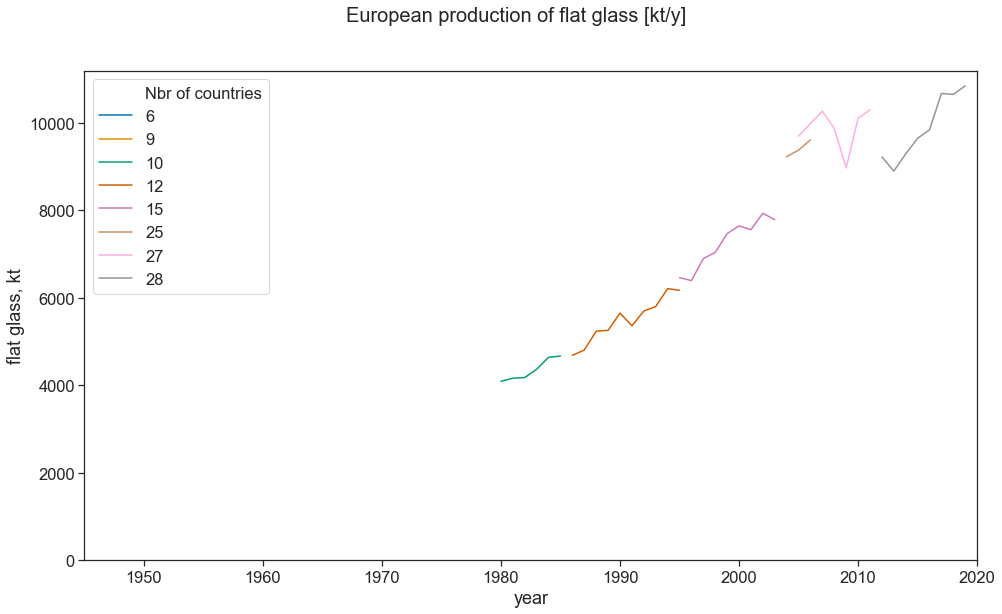

In [11]:
#Plot the European production of flat glass

EUplot = EU_Prod.reset_index()
fig, ax = plt.subplots()

sns.lineplot(data = EUplot, x = 'year', y = 'flat glass, kt', 
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('European production of flat glass [kt/y]', fontsize = 20)

Text(0.5, 0.98, 'Flat glass production [kt/y]')

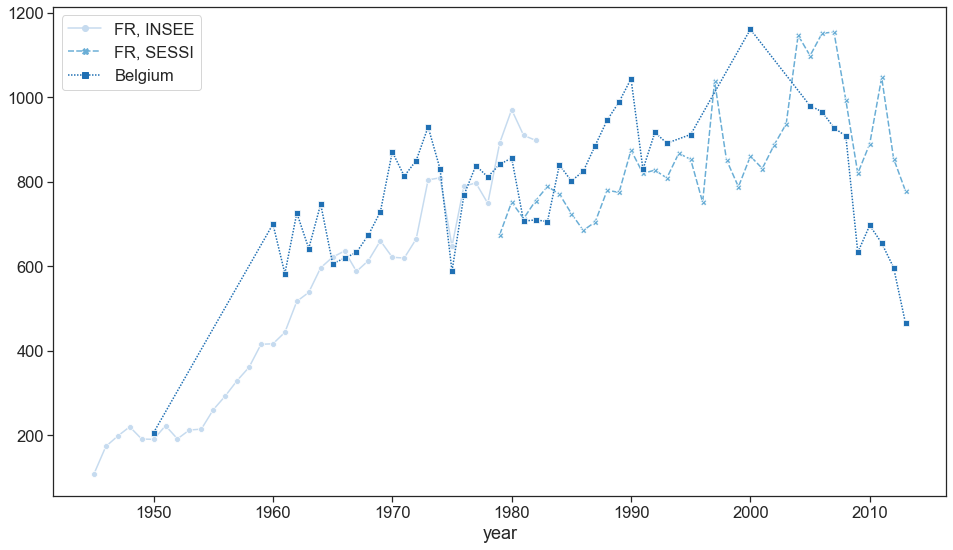

In [12]:
#Plot FR and BE flat glass production

sns.lineplot(data=BE_FR_Prod, markers=True, palette="Blues")

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('Flat glass production [kt/y]', fontsize = 20)

## b. Production of architectural flat glass

In [13]:
#Share of building glazing in the French production of flat glass
ShareFR = FR_Prod[['bldg glass/flat glass, %']].dropna()
ShareFR

,"bldg glass/flat glass, %"
year,
1947,0.90
1952,0.80
1962,0.68
1968,0.50
1980,0.50
1994,0.50
2002,0.52
2004,0.49


In [14]:
ShareFR.isnull().sum()

bldg glass/flat glass, %    0
dtype: int64

Text(0.5, 0.98, 'Share of building glass in the European flat glass production, %')

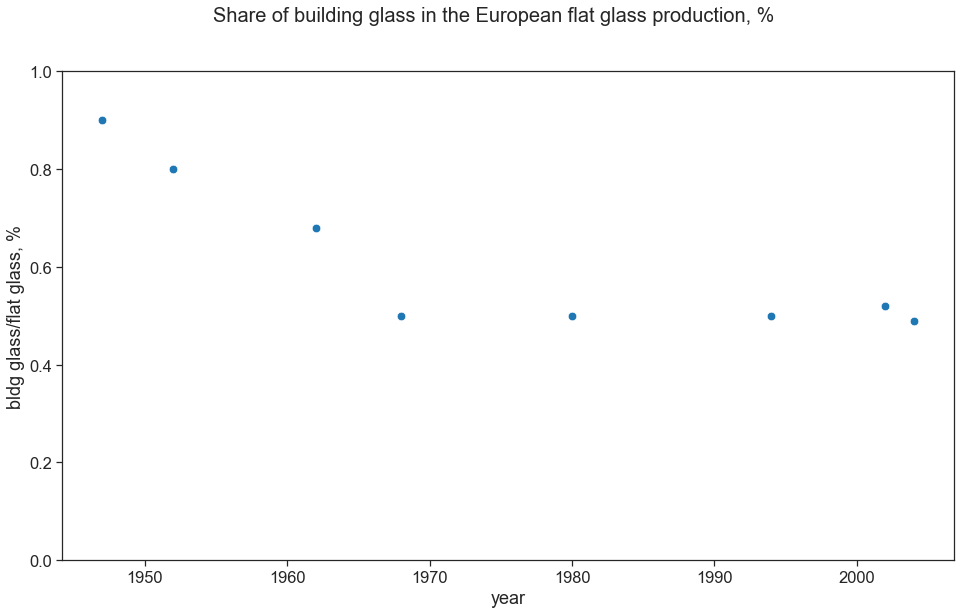

In [15]:
ShareFR = ShareFR.reset_index()
fig, ax = plt.subplots()

sns.scatterplot(data = ShareFR, x = 'year',
                y = 'bldg glass/flat glass, %', 
                s=75, ax = ax)

ax.set_ylim(0,1)
fig.suptitle('Share of building glass in the European flat glass production, %', 
             fontsize = 20)

In [16]:
#Estimating parameters a and b of the regression lines

ShareFR['Trend1'] = ShareFR['bldg glass/flat glass, %'][:4]
ShareFR['Trend2'] = ShareFR['bldg glass/flat glass, %'][-5:]

x1 = list(ShareFR['year'][:4])
y1 = list(ShareFR['Trend1'][:4])
a1, b1 = np.polyfit(x1, y1, 1)

x2 = list(ShareFR['year'][-5:])
y2 = list(ShareFR['Trend2'][-5:])
a2, b2 = np.polyfit(x2, y2, 1)

Approximate year of rate change: 1970.0


Text(0.5, 0.98, 'Share of building glass in the French production of flat glass, %')

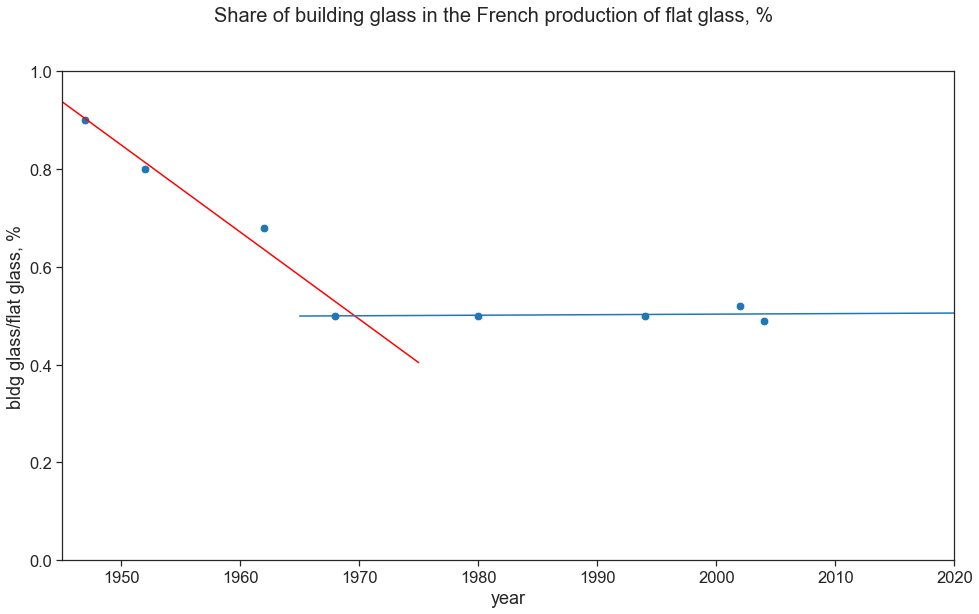

In [17]:
#Plotting the regression lines
fig, ax = plt.subplots()

sns.scatterplot(data = ShareFR, x = 'year',
                y = 'bldg glass/flat glass, %', 
                s=75, ax = ax)

A = np.linspace(1945,1975)
ax.plot(A, a1 * A + b1, color='red')
B = np.linspace(1965,2020)
ax.plot(B, a2 * B + b2)

#Point of intersection of the two regression lines
xi = (b1-b2) / (a2-a1)
print('Approximate year of rate change:', round(xi,0))

#A few plot parameters
ax.set_xlim(1945,2020)
ax.set_ylim(0,1)
fig.suptitle('Share of building glass in the French production of flat glass, %', 
             fontsize = 20)

C:\Users\souvi\Miniconda3\envs\PhD_Python\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\souvi\Miniconda3\envs\PhD_Python\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\souvi\Miniconda3\envs\PhD_Python\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added b

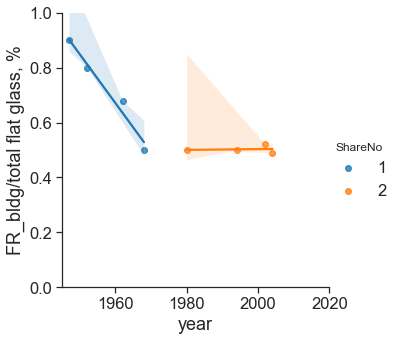

In [18]:
BE_FR_Prod['FR_bldg/total flat glass, %'] = FR_Prod['bldg glass/flat glass, %']
BE_FR_Prod['Share'] = ""
BE_FR_Prod['ShareNo'] = ""
BE_FR_Prod = BE_FR_Prod.reset_index()

for i in BE_FR_Prod.index:
    if BE_FR_Prod['year'][i] < xi:
        BE_FR_Prod['Share'][i] = round((a1 * BE_FR_Prod['year'][i] + b1),2)
        BE_FR_Prod['ShareNo'][i] = 1
    else:
        BE_FR_Prod['Share'][i] = round((a2 * BE_FR_Prod['year'][i] + b2),2)
        BE_FR_Prod['ShareNo'][i] = 2

g = sns.lmplot(data=BE_FR_Prod, x='year', y='FR_bldg/total flat glass, %', 
           hue='ShareNo')
g = g.set(xlim=(1945,2020), ylim=(0,1))

In [ ]:
BE_FR_Prod['FR architectural flat glass, kt'] = BE_FR_Prod['']

In [19]:
#Share of building glazing in the European production of flat glass
RatioEU = EU_Prod[['bldg glass/flat glass, %']].dropna()
RatioEU

bldg glass/flat glass, %
Nbr of countries year                                               
9                1978                                          0.572
15               1995                                               
                 1996                                           0.52
28               2018                                            0.8

## c. Production of insulating glass units